In [15]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib
from scipy import stats, optimize
from scipy.optimize import nnls

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue.dynamics.planar_gradients import area_grad
from tyssue_taylor.adjusters.adjust_annular import (prepare_tensions, adjust_tensions,
                                                    adjust_areas, adjust_scale, adjust_parameters)
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model, lumen_area_grad
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces, _coef_matrix, _right_side
from tyssue_taylor.models.display import (create_organo, print_tensions, rendering_results,
                                          rendering_convergence_results,
                                          plot_force_inference)

In [16]:
def create_organo(nb_cells, r_in, r_out, seed=None, rot=None, geom=geom):
    organo = generate_ring(nb_cells, r_in, r_out)
    Nf = organo.Nf
    geom.update_all(organo)
    alpha = 1 + 1/(20*(organo.settings['R_out']-organo.settings['R_in']))
    specs = {
        'face': {
            'is_alive': 1,
            'prefered_area': organo.face_df.area,
            'area_elasticity': 1., },
        'edge': {
            'ux': 0.,
            'uy': 0.,
            'uz': 0.,
            'line_tension': 0.1,
            'is_active': 1
            },
        'vert': {
            'adhesion_strength': 0.01,
            'x_ecm': 0.,
            'y_ecm': 0.,
            'is_active': 1
            },
        'settings': {
            'lumen_elasticity': 0.1,
            'lumen_prefered_vol': organo.settings['lumen_volume'],
            'lumen_volume': organo.settings['lumen_volume']
            }
        }
    organo.update_specs(specs, reset=True)
    normalize_scale(organo, geom, refer='edges')
    geom.update_all(organo)
    if seed is not None:
        symetric_tensions = set_init_point(organo.settings['R_in'],
                                           organo.settings['R_out'],
                                           organo.Nf, alpha)
        sin_mul = 1+(np.sin(np.linspace(0, 2*np.pi, organo.Nf,
                                        endpoint=False)))**2
        organo.face_df.prefered_area *= np.random.normal(1.0, 0.05, organo.Nf)
        organo.edge_df.line_tension = prepare_tensions(organo,
                                                       symetric_tensions)
        organo.edge_df.loc[:Nf-1, 'line_tension'] *= sin_mul*np.random.normal(
            1.0, 0.05, organo.Nf)
        geom.update_all(organo)
    if rot is not None:
        organo.vert_df.loc[:, 'x'] = (organo.vert_df.x.copy() * np.cos(rot) -
                                      organo.vert_df.y.copy() * np.sin(rot))
        print('rotated x',
              organo.vert_df.x.copy() * np.cos(rot) -
              organo.vert_df.y.copy() * np.sin(rot))
        organo.vert_df.loc[:, 'y'] = (organo.vert_df.x.copy() * np.sin(rot) +
                                      organo.vert_df.y.copy() * np.cos(rot))
        print('rotated y',
              organo.vert_df.x.copy() * np.sin(rot) +
              organo.vert_df.y.copy() * np.cos(rot))
        geom.update_all(organo)
    organo.vert_df[['x_ecm', 'y_ecm']] = organo.vert_df[['x', 'y']]
    organo.vert_df.loc[organo.basal_verts, 'adhesion_strength'] = 0.01
    new_tensions = organo.edge_df.line_tension
    organo.edge_df.loc[:, 'line_tension'] = new_tensions
    return organo

In [28]:
def get_sim_mat(Nf, Ra, Rb, sum_lbda=1e-2):

    sin_t = np.sin(np.pi/Nf)
    sin_2t = np.sin(2*np.pi/Nf)

    A = 0.5 * (Rb**2 - Ra**2) * sin_2t
    dAdRa = - sin_2t * Ra
    dAdRb = sin_2t * Rb
    dladRa = dlbdRb = 2*sin_t

    # variables are
    # (A - A_0), \Lambda_a, \Lambda_h
    problem_mat = np.array(
        [
            [dAdRa, dladRa, -1],
            [dAdRb, 0,       1],
            [0,     1,       1]
        ])

    b = np.array([0, 0, sum_lbda])
    return problem_mat, b

Reseting datasets values with new specs


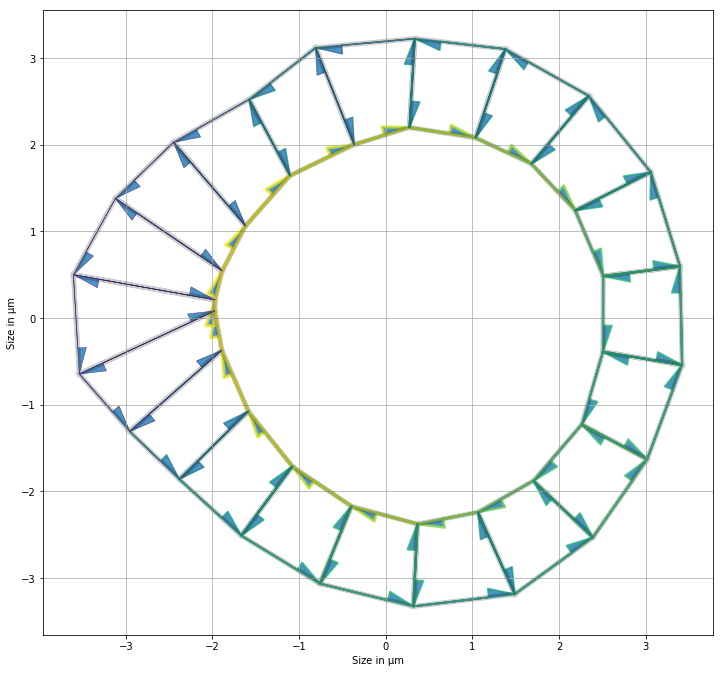

In [17]:
nf, r_in, r_out = (20, 1, 1.5)
seed = 1
organo = create_organo(nf, r_in, r_out)

organo.edge_df.loc[organo.apical_edges, 'line_tension'] = 3*np.array([
    0.050, 0.055, 0.060, 0.065, 0.070,
    0.072, 0.074, 0.076, 0.078, 0.078,
    0.079, 0.078, 0.076, 0.074, 0.072,
    0.070, 0.068, 0.065, 0.057, 0.052
])

organo.edge_df.loc[organo.basal_edges, 'line_tension'] = 3*np.array([
    0.050, 0.055, 0.050, 0.045, 0.050,
    0.050, 0.045, 0.035, 0.020, 0.010,
    0.011, 0.015, 0.020, 0.035, 0.030,
    0.040, 0.040, 0.042, 0.045, 0.050
])

organo.edge_df.loc[organo.lateral_edges, 'line_tension'] = 3*np.array([
    0.050, 0.055, 0.050, 0.044, 0.051,
    0.051, 0.046, 0.034, 0.019, 0.009,
    0.010, 0.014, 0.021, 0.036, 0.029,
    0.041, 0.039, 0.043, 0.046, 0.051,
    0.055, 0.050, 0.044, 0.051,
    0.051, 0.046, 0.034, 0.019, 0.009,
    0.010, 0.014, 0.021, 0.036, 0.029,
    0.041, 0.039, 0.043, 0.046, 0.051, 0.050
])

organo.face_df.loc[:, 'prefered_area'] = np.array([
    0.08, 0.07, 0.08, 0.09, 0.09,
    0.10, 0.09, 0.08, 0.09, 0.09,
    0.10, 0.11, 0.10, 0.11, 0.12,
    0.11, 0.10, 0.09, 0.08, 0.09
]) + organo.face_df.area

geom.update_all(organo)
Solver.find_energy_min(organo, geom, model)
print_tensions(organo, organo)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2e2a396a58>)

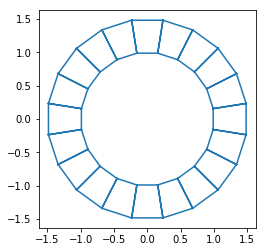

In [18]:
sym_org = generate_ring(nf, r_in, r_out)
geom.update_all(sym_org)
quick_edge_draw(sym_org)

In [24]:
#selectionner les coordonnées des vertex apicaux
api_vertex = organo.vert_df.loc[organo.apical_verts, ('x', 'y')]
#centre des cellules
cell_centers = organo.face_df.loc[:, ('x', 'y')]

In [25]:
api_vertex.head()

,x,y
vert,,
0,2.505490,-0.389034
1,2.260841,-1.227482
2,1.704032,-1.876593
3,1.063769,-2.239495
4,0.366279,-2.375904


In [26]:
cell_centers.head()

,x,y
face,,
0,2.800145,-0.947523
1,2.342210,-1.816765
2,1.660884,-2.458632
3,0.808607,-2.782078
4,-0.118299,-2.734780


## Matrice et constante de l'inférence de forces

In [27]:
matrix = _coef_matrix(organo, sup_param='areas')
constant = _right_side(organo, matrix)

Calcul des paramètres dans l'organoïde régulier

In [ ]:
params_in_sym_mesh = np.linalg.solve(*get_sim_mat(nf, r_in, r_out))

Calcul du "coefficient de polarisation", avec le rapport de la hauteur des trapèzes (osbolète)

In [33]:
organo.get_extra_indices()
non_lateral_edges = np.concatenate((organo.apical_edges,
                                    organo.basal_edges))
sym_height = (r_out-r_in)*np.cos(np.pi/organo.Nf)
polar_coefs = np.ones(organo.Nf)
for cell in range(organo.Nf):
    parrallel_edges = (organo.edge_df.loc[non_lateral_edges, ('srce', 'trgt')]
                       [organo.edge_df.face == cell]).values
    apical_middle = organo.vert_df.loc[parrallel_edges[0, :], ('x', 'y')].sum()/2
    basal_middle = organo.vert_df.loc[parrallel_edges[1, :], ('x', 'y')].sum()/2
    cell_height = np.linalg.norm(apical_middle - basal_middle)
    polar_coefs[cell] = cell_height/sym_height
polar_coefs

/home/felix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


array([1.7804046 , 1.80896929, 1.97237282, 1.95819428, 1.91354156,
       1.9663041 , 2.13011039, 2.5651894 , 3.14946586, 3.26946007,
       3.11867021, 2.77275355, 2.28573431, 2.22316687, 2.20358018,
       2.11542926, 2.09600265, 1.99059355, 1.86836   , 1.82366071])

In [ ]:
organo.get_extra_indices()
non_lateral_edges = np.concatenate((organo.apical_edges,
                                    organo.basal_edges))
sym_height = (r_out-r_in)*np.cos(np.pi/organo.Nf)
polar_coefs = np.ones(organo.Nf)
for cell in range(organo.Nf):
    #(((C(1,1)-A(1,1))*(B(1,1)-A(1,1)))+((C(1,2)-A(1,2))*(B(1,2)-A(1,2))))
    api_vert = organo.vert_df.loc[(cell, (cell+1)%organo.Nf), ('x', 'y')]
    print(api_vert)
    #cell_center = 
    #t = np.dot(, AB )) / norme( AB )^2
    #t = min( max( 0, t ), 1 )
    #P' = A + AB*t
    #distance = norme( PP' )
polar_coefs

Modification du système d'inférence de forces pour faire apparaître les contraintes sur la somme des tensions dans les cellules


[0.021858713913633355, 0.021858713913633355, 0.021858713913633355, 0.021858713913633355, 0.021858713913633355, 0.021858713913633355, 0.021858713913633355, 0.021858713913633355, 0.021858713913633355, 0.021858713913633355, 0.021858713913633355, 0.021858713913633355, 0.021858713913633355, 0.021858713913633355, 0.021858713913633355, 0.021858713913633355, 0.021858713913633355, 0.021858713913633355, 0.021858713913633355, 0.021858713913633355]
[0.03891735 0.03954174 0.04311353 0.04280361 0.04182756 0.04298088
 0.04656147 0.05607174 0.06884327 0.07146619 0.06817012 0.06060883
 0.04996321 0.04859557 0.04816743 0.04624056 0.04581592 0.04351182
 0.04083995 0.03986288]
Apical tensions:  [0.03790558 0.03580155 0.04191273 0.04430707 0.0411616  0.0442671
 0.04744289 0.0560637  0.06974954 0.0813411  0.07748918 0.06848368
 0.05920607 0.04960424 0.05717055 0.04441628 0.0489642  0.04342749
 0.04074936 0.03678701] 
Basal tensions:  [0.03233953 0.03117447 0.0320774  0.0299639  0.02811553 0.02924351
 0.0285

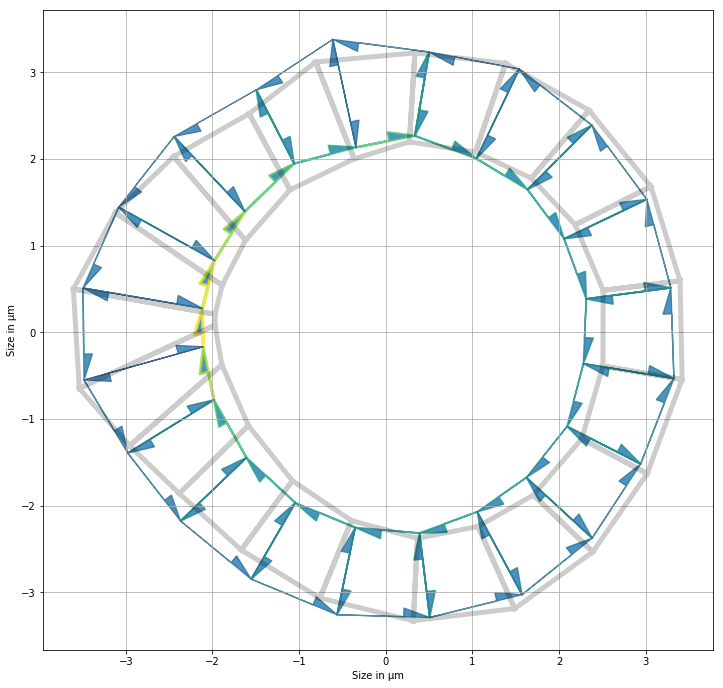

In [32]:
avg_cste = [4*((params_in_sym_mesh[1:].sum()+params_in_sym_mesh[-1])/3 /
               (organo.face_df.area.mean() + params_in_sym_mesh[0])**1.5)]*organo.Nf
print(avg_cste)
avg_cste = np.multiply(np.array(avg_cste), polar_coefs)
print(avg_cste)
for i in range(organo.Nf):
    i_cell_line = np.zeros(4*organo.Nf+1)
    index = np.squeeze(np.argwhere(organo.edge_df.face.values == i)[:-1])
    i_cell_line[index] = 1
    matrix = np.vstack((matrix, i_cell_line))
constant = np.concatenate((constant, avg_cste))
mat_eq_cst, residuals = nnls(matrix, constant)
organo_eq_cst = organo.copy()
organo_eq_cst.edge_df.loc[:, 'line_tension'] = prepare_tensions(organo_eq_cst,
                                                                 mat_eq_cst[:3*organo.Nf])
organo_eq_cst.face_df.loc[:, 'prefered_area'] = organo_eq_cst.face_df.area + mat_eq_cst[3*organo.Nf:
                                                                                          4*organo.Nf]
organo_eq_cst.settings['lumen_prefered_vol'] = organo_eq_cst.settings['lumen_volume'] + mat_eq_cst[-1]
Solver.find_energy_min(organo_eq_cst, geom, model)
print_tensions(organo_eq_cst, organo)
print('Apical tensions: ', mat_eq_cst[organo.apical_edges],
      '\nBasal tensions: ', mat_eq_cst[organo.basal_edges],
      '\nLateral tensions: ', mat_eq_cst[organo.lateral_edges[:organo.Nf]],
      '\nArea elasticity: ', mat_eq_cst[organo.Nf*3:-1],
      '\nLumen area elasticity: ', mat_eq_cst[-1],
      '\nDistance from th org to exp org: ', np.sum(np.linalg.norm(_distance(organo_eq_cst, organo), axis=1)),
      '\nNNLS residuals: ', residuals)